In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import utils.data
from utils.model import transformer_classifier
from utils.layers import *
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
data = utils.data.get_dataset(mode='mel')

In [3]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [4]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [5]:
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0, dtype=np.float32)

In [6]:
# X_train = (X_train - mean) / std
# X_valid = (X_valid - mean) / std
# X_test  = (X_test - mean) / std

In [7]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [8]:
num_samples = X_train.shape[0]

# Generate a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Shuffle X_train and Y_train using the random indices
X_train = X_train[random_indices]
Y_train = Y_train[random_indices]

In [9]:
num_layers=8
d_model=utils.data.n_mfcc_mel
num_heads=4
dff=256
maximum_position_encoding=utils.data.num_mfcc_vectors_per_segment
n_classes=len(data["mapping"])

In [10]:
model = transformer_classifier(num_layers, d_model, num_heads, dff, maximum_position_encoding, n_classes)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44, 128)]         0         
                                                                 
 encoder (Encoder)           (None, 44, 128)           2641920   
                                                                 
 dropout_25 (Dropout)        (None, 44, 128)           0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_16 (Dense)            (None, 60)                7740      
                                                                 
 dropout_26 (Dropout)        (None, 60)                0         
                                                             

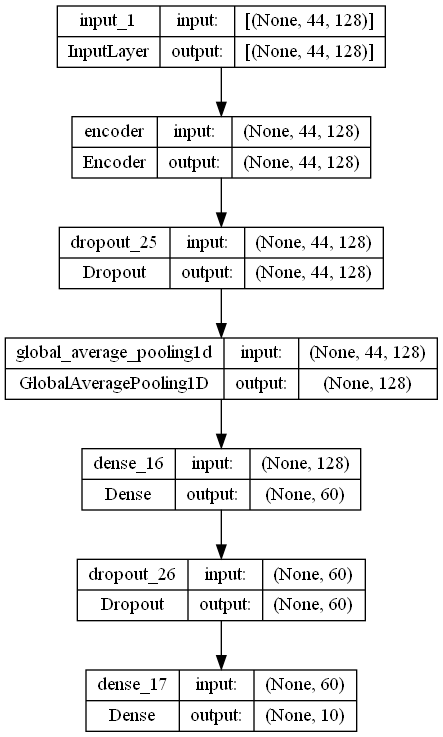

In [11]:
tf.keras.utils.plot_model(model,"model.png", show_shapes = True,)

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [13]:
reduce_o_p = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=20, min_lr=1e-7, mode="min")

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "./models/transformer.h5",
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="auto",
        save_weights_only=True,
    )

In [15]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), callbacks=[checkpoint, es])

Epoch 1/50
656/656 [==============================] - ETA: 0s - loss: 1.7910 - accuracy: 0.4435
Epoch 1: val_accuracy improved from -inf to 0.39022, saving model to ./models\transformer.h5
656/656 [==============================] - 54s 72ms/step - loss: 1.7910 - accuracy: 0.4435 - val_loss: 2.5863 - val_accuracy: 0.3902
Epoch 2/50
656/656 [==============================] - ETA: 0s - loss: 1.1568 - accuracy: 0.6033
Epoch 2: val_accuracy improved from 0.39022 to 0.46101, saving model to ./models\transformer.h5
656/656 [==============================] - 47s 72ms/step - loss: 1.1568 - accuracy: 0.6033 - val_loss: 2.3206 - val_accuracy: 0.4610
Epoch 3/50
656/656 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.6709
Epoch 3: val_accuracy did not improve from 0.46101
656/656 [==============================] - 47s 71ms/step - loss: 0.9534 - accuracy: 0.6709 - val_loss: 2.5487 - val_accuracy: 0.4542
Epoch 4/50
656/656 [==============================] - ETA: 0s - loss: 0.8

In [16]:
print("predicted:\t",np.argmax(model.predict(tf.expand_dims(X_test[55], axis=0))))
print("actual:\t\t",np.argmax(Y_test[55]))

1/1 [==============================] - 1s 831ms/step
predicted:	 4
actual:		 0


94/94 [==============================] - 3s 25ms/step
              precision    recall  f1-score   support

           0       0.30      0.07      0.11       300
           1       0.78      0.86      0.82       299
           2       0.51      0.48      0.49       299
           3       0.43      0.55      0.48       299
           4       0.45      0.73      0.55       299
           5       0.47      0.60      0.53       297
           6       0.45      0.78      0.57       300
           7       0.79      0.70      0.74       300
           8       0.16      0.05      0.07       300
           9       0.48      0.29      0.36       299

    accuracy                           0.51      2992
   macro avg       0.48      0.51      0.47      2992
weighted avg       0.48      0.51      0.47      2992



<Axes: >

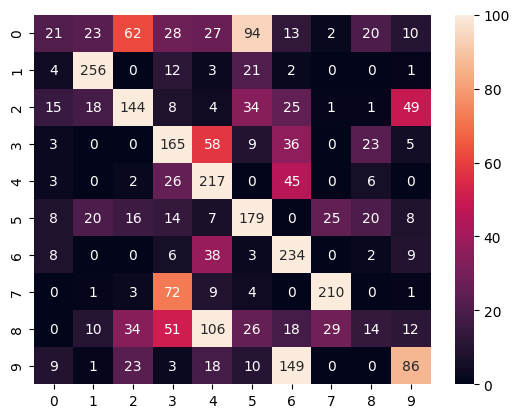

In [17]:
preds = model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [18]:
for i in range(len(data["mapping"])):
    print(str(i) + ":\t" + data["mapping"][i])

0:	blues
1:	classical
2:	country
3:	disco
4:	hiphop
5:	jazz
6:	metal
7:	pop
8:	reggae
9:	rock


In [19]:
# pred_model = model.load_weights("./models/transformer2.h5")

In [20]:
np.argmax(model.predict(tf.expand_dims(X_test[55], axis=0)))

1/1 [==============================] - 0s 34ms/step


4

In [23]:
import librosa
from utils.data import *

In [33]:
def predict_genre(signal, sr):
    segments = []
    for i in range(number_of_segments):
        # calculating start and finish index of the segment
        start = samples_per_segment * i
        end = start + samples_per_segment
        # Calculating the mfcc of the segment
        feature = librosa.feature.melspectrogram(y=signal[start:end], sr=sr, n_mels=n_mfcc_mel, n_fft=n_fft, hop_length=hop_length)
        feature = (librosa.power_to_db(feature, ref=np.max) + 40) / 40
        feature = feature.T.tolist()
        if len(feature) == num_mfcc_vectors_per_segment:
            # Adding the mfcc and label to our data
            segments.append(feature)
        
    segments = np.array(segments)
    sum = np.zeros(10)
    for segment in segments:
        sum[np.argmax(model.predict(tf.expand_dims(segment, axis=0), verbose=0))] += 1
    pred = np.argmax(sum)
    return data["mapping"][pred]
    

In [42]:
from IPython.display import display
from IPython.display import Audio

In [44]:
for i in range(80, 99):
    signal, sr = librosa.load('./Data/genres_original/blues/blues.000'+str(i)+'.wav', sr=22050)
    # display(Audio('./Data/genres_original/blues/blues.0000'+str(i)+'.wav'))
    print(predict_genre(signal, sr))

disco
metal
rock
disco
disco
country
country
jazz
country
jazz
hiphop
reggae
jazz
classical
jazz
country
classical
country
disco
